# **Random Forest Classifier**

In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [3]:
train_data.columns

Index(['points', 'cyclist_age', 'is_tarmac', 'cyclist_level',
       'avg_relative_position', 'avg_rel_position_profile', 'length_cat',
       'climb_cat', 'avg_cyclist_level', 'top_20_entropy'],
      dtype='object')

## Preprocessing Pipeline

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_features = ['is_tarmac', 'length_cat', 'climb_cat']
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)
    ])

## Decision Tree Model

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score

In [6]:
clf = DecisionTreeClassifier(splitter='best', class_weight='balanced')

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", clf)]
)


params = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__max_depth': [2, 4, 6],
    'clf__min_samples_split': [2, 4, 6, 8 ,10],
    'clf__min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250],
    'clf__max_features': ['sqrt', 'log2', None]
}

scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=5, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['points',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'avg_relative_position',
                                                                                'avg_rel_position_profile',
                                                                                'avg_cyclist_level',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['is_tarmac',
                                                                                'length_cat',
                                                                                'climb_cat'])])),
                                             ('clf',
                                              De...
                            'f1': make_scorer(f1_score, response_method='predict', average=binary),
                            'precision': make_scorer(precision_score, response_method='predict', average=binary),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(recall_score, response_method='predict', average=binary),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

Accuracy: 0.7099108117946851
Recall: 0.7154445849136115
Precision: 0.29252638380357526
Sensitivity: 0.7154445849136115
Specificity: 0.7089800836345596
F1 Score: 0.4152627877824319
ROC AUC Score: 0.7122123342740855


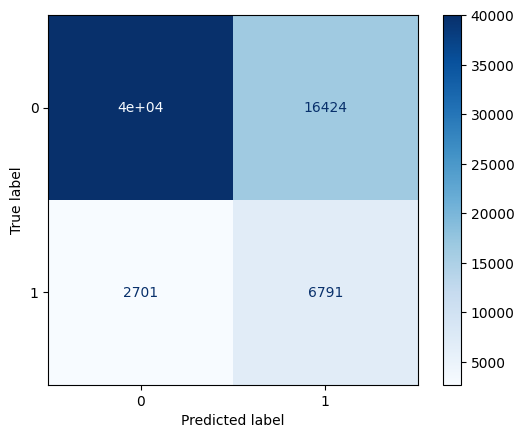

In [7]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
sensitivity_score = sensitivity_score(test_labels, test_predictions)
specificity_score = specificity_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


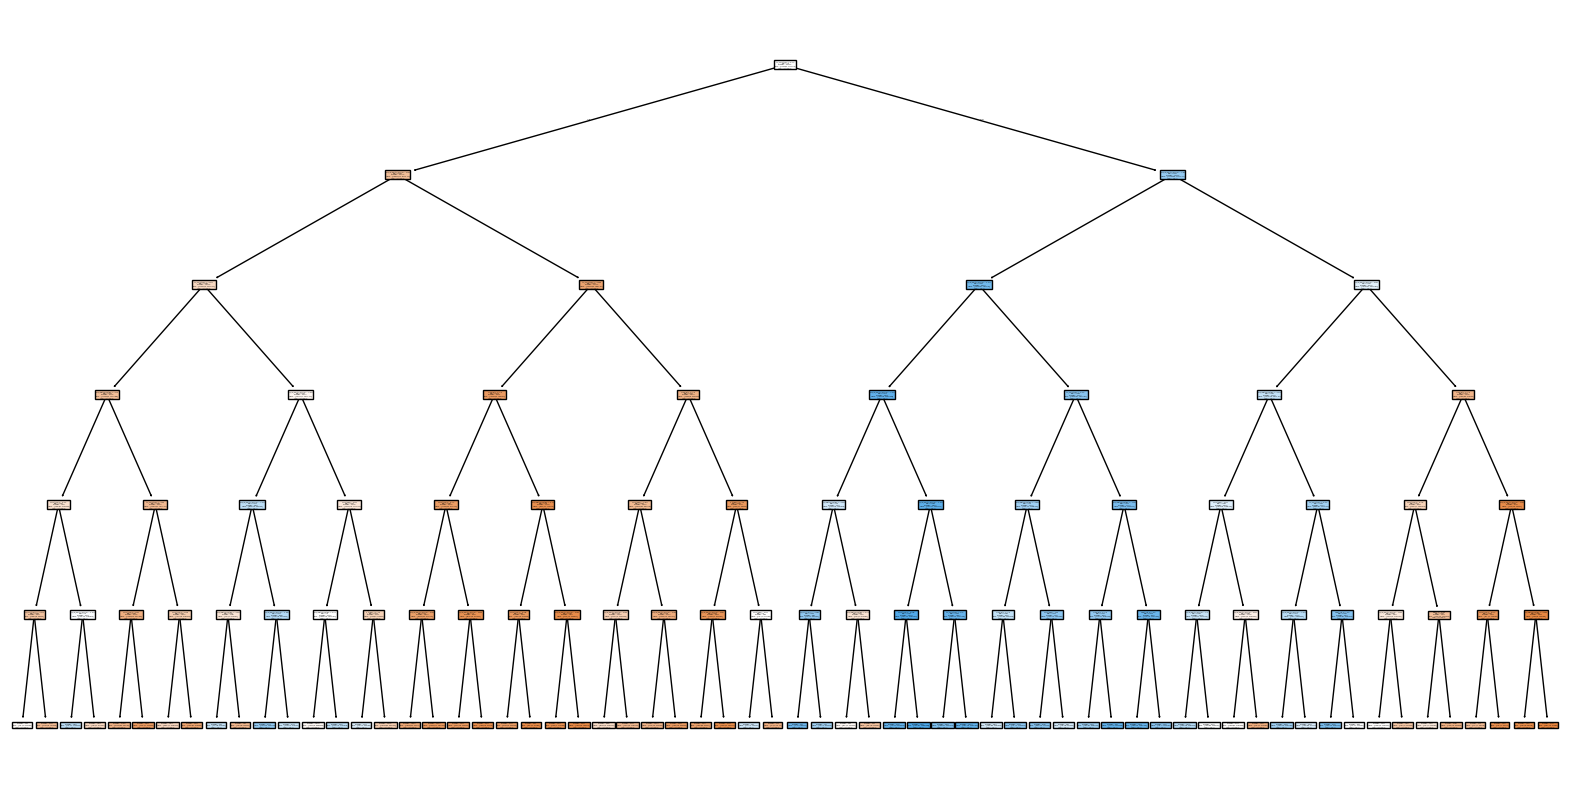

In [12]:
from sklearn.tree import plot_tree

# Get the best estimator from the RandomizedSearchCV
best_model = rscv.best_estimator_
best_dt = best_model.named_steps["clf"]

cat_transformer = rscv.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"]  # Nome assegnato al transformer categorizzato
cat_feature_names = cat_transformer.get_feature_names_out(cat_features)

all_features = numeric_features + cat_feature_names.tolist()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=all_features, class_names=['Not Top 20', 'Top 20'], filled=True)
plt.show()